In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import dns

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from h3 import h3
import datetime
import imageio
import json
import os
import pickle
import collections
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras import metrics

from tensorflow.keras.callbacks import *
from sklearn.preprocessing import StandardScaler

from keras import backend as K 

import shap


Using TensorFlow backend.


In [2]:
## Lectura de los archivos que previamente fueron creados con el archivo "lstm_data_processing.iypynb"
## Los archivos que se generan fueron guardados en una carpeta temporal que no se incluirá en el git.

data_path = '../temp_data'
df = pd.read_pickle(data_path+'/346-ver20_ips_processed_groups_res8.pickle')
resolution = 8
geo_clinicas = {'FUNDACION VALLE DEL LILI':[3.372909 ,-76.526586] , 
                'CENTRO MEDICO IMBANACO': [3.423411, -76.543959], 
                'CLINICA VERSALLES SA': [3.464051, -76.528204],  
                'HOSPITAL UNIVERSITARIO DEL VALLE EVARISTO GARCIA': [3.429724, -76.544600]}

clinicas =['FUNDACION VALLE DEL LILI',
          'CENTRO MEDICO IMBANACO',
          'CLINICA VERSALLES SA',
          'HOSPITAL UNIVERSITARIO DEL VALLE EVARISTO GARCIA']

with open(data_path+'/city_hex.pickle', 'rb') as handle:
    city_hex = pickle.load(handle)
with open(data_path+'/city_hex_copy.pickle', 'rb') as handle:
    city_hex_copy = pickle.load(handle)
with open(data_path+'/neighbors_copy.pickle', 'rb') as handle:
    neighbors_copy= pickle.load(handle)
with open(data_path+'/population_per_hex.pickle', 'rb') as handle:
    population_per_hex= pickle.load(handle)
with open(data_path+'/population_per_commune.pickle', 'rb') as handle:
    population_per_commune= pickle.load(handle)
with open(data_path+'/population_per_neighbor.pickle', 'rb') as handle:
    population_per_neighbor= pickle.load(handle)
with open(data_path+'/population_per_group.pickle', 'rb') as handle:
    population_per_group = pickle.load(handle)
with open(data_path+'/data_days_comunas.pickle', 'rb') as handle:
    data_days_comunas = pickle.load(handle)   
with open(data_path+'/data_days_groups.pickle', 'rb') as handle:
    data_days_groups = pickle.load(handle)    
with open(data_path+'/data_days_hex.pickle', 'rb') as handle:
    data_days_hex = pickle.load(handle)    
with open(data_path+'/dict_groups.pickle', 'rb') as handle:
    dict_groups = pickle.load(handle)

#### funciones

In [3]:
def error_metrics(y, preds):
    """ procedimiento que permite calcular las métricas de error: mse, rmse, mae,mape.

    Parameters
    ----------
    y : list
        Valores reales.
    
    preds : list
        Predicciones
    
    Imprime
    -------
        MSE, RMSE, MAE, MAPE
        
    """
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    print("MSE: %f" % (mse))
    print("RMSE: %f" % (rmse))
    print("MAE: %f" % (mae))
    print("MAPE: %f" % (mape))
    print()
    
def error_analysis(df, title, path,scaled = False,ac='semana -1',pr = 'predictions'):
    """ Procedimiento que realiza un análisis de los errores en los diferentes cuartiles.

    Parameters
    ----------
    df : DataFrame
        Contiene toda la información de los valores reales y predicciones.
    
    title : String
        Titulo de las figuras que se van a guardar.
        
    path : String
        Path donde se van a guardar las figuras.
        
    scaled : Bool
        Valor que permite saber si los datos estan normalizados o no.
        
    ac : String
        Nombre de la columna donde se encuentran los valores reales.
    pr : String
        Nombre de la columna donde se encuentran las predicciones.
    
    
    Imprime
    -------
    Metricas de la función "error_metrics" para cada cuantil.
    Genera una figura de la distribución de los errores.
    """
    
    if scaled: actual=0
    else: actual=ac
    y_total = df[actual]
    preds = df[pr]
    error_metrics(y_total, preds)
    
    quantiles= list(y_total.quantile([0 ,.25, .5, .75, 1]))  
    queries = [
               y_total < quantiles[1], 
               (y_total >= quantiles[1]) & (y_total< quantiles[2]),
               (y_total >= quantiles[2]) & (y_total < quantiles[3]),
               y_total >= quantiles[3]
              ]
    
    df_q = [df[queries[0]],df[queries[1]],df[queries[2]],df[queries[3]]]
    for i,dfm in enumerate(df_q):
        print('Quantile {}, between {} and {}'.format(i+1,quantiles[i],quantiles[i+1]))
        error_metrics(dfm[actual], dfm[pr])
    
    fig, ax = plt.subplots(figsize=(6, 4))
    y = y_total
    ax.scatter(y, preds)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.plot([y.min(), y.max()], [y.min()*1.25, y.max()*1.25], 'b--', lw=1)
    ax.plot([y.min(), y.max()], [y.min()*0.75, y.max()*0.75], 'b--', lw=1)
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicted')
    plt.title(title)
    plt.savefig(path, dpi=500)
    plt.show()
    
def mean_absolute_percentage_error(y_true, y_pred): 
    """ métrica MAPE hecha manualmente para trabajar personalmente con las divisiones por cero.

    Parameters
    ----------
    y_true : list
        Valores reales.
    
    y_pred : list
        Predicciones
    

    Returns
    -------
    MAPE

    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ape = (y_true - y_pred) / y_true
    ape_no_inf = [x if np.abs(x) != float('inf') else 0 for x in ape]
    return np.mean(np.abs(ape_no_inf)) * 100

def plt_map_image(data,col,title,ax):    
    """ Función que permite graficar rápidamente los hexagonos de Cali en blanco con algún otro dato

    Parameters
    ----------
    data : DataFrame
        Tabla con los valores que se quieren graficar.
    
    col: String
        Nombre de la columna a graficar.
    
    title : String
        Titulo de la imagen.
    
    ax : int/list
        Posición donde se quiere graficar.
    

    Returns
    -------
    Figura

    """
    city_hex.plot(color="white", edgecolor='0.1', linewidth=0.4, figsize=(12, 7),ax=ax)
    data.plot(column=col, edgecolor='0.6', linewidth=0.3, cmap='YlOrRd', legend=True, ax=ax);
    ax.set_title(title)
    
### UTILITY FUNCTIONS FOR TARGET SCALING ###
def scale_target(y, mean, std):
    return (y - mean)/std

def reverse_target(pred, mean, std): 
    return pred*std + mean

def plot_results(predicted_data, true_data): 
    """ Función que permite graficar la distribucion de las predicciones.

    Parameters
    ----------
    predicted_data : List
        Predicciones
    
    true_data : List
        Valores reales.

    Returns
    -------
    Figura

    """
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show()

### Long short term model - LSTM modifications and analysis


In [4]:
def split_data_columns(df1,df2,n_col,days):
    """ Función que separa los datos de test y training, utilizando dos dataframes, uno de historial y otro de target.
       no uso la función de sklearn debido a que no necesito datos aleatorios, si no que debo seguir las series de tiempo.

    Parameters
    ----------
    df1 : DataFrame
        Tabla con los valores espacio temporales para los atributos. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    df2 : DataFrame
        Tabla con los valores espacio temporales para los targets. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
    
    n_col : int
        Número de la columna que se quiere predecir para retornarla como target (y).
    
    days : int
        Número de días que se quieren de test.
        
    Returns
    -------
    X_train : DataFrame
        Atributos para el entrenamiento.
        
    y_train : DataFrame
        Target para el entrenamiento.
        
    X_test : DataFrame
        Atributos para el test.
        
    y_test : DataFrame
        Target para el test.

    """
    data_days_hist = df1.copy()
    data_days_targ = df2.copy()
    
    y= data_days_targ.iloc[:,n_col]
    x= data_days_hist.drop(data_days.columns[n_col], axis=1)
    
    X_test,y_test = x.iloc[-days:],y.iloc[-days:]
    X_train,y_train = x.iloc[:-days],y.iloc[:-days]
    #X_train = X_train.values.reshape((X_train.shape[0],1, X_train.shape[1]))
    X_test= X_test.values.reshape((1,X_test.shape[0], X_test.shape[1]))
    return X_train, y_train, X_test, y_test

In [5]:
def acum_population_levels(dff, rang, level,  acum = False):
    """ cambiar

    Parameters
    ----------
    
    df : Dataframe 
        Tabla con los valores espacio temporales. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    rang: Tupla/Lista 
        Contiene las posiciones inicio fin de columnas para ser cambiadas. 
        Si tiene un elemento, indica que va hasta el final.
          
    level: int
        Nivel de resolucion de los datos. Un nivel de 100 me daria un valor x (caso) entre 100 personas.
        
    acum: Bool
        generar o no los datos en forma acumulada en los días para tener comportamientos crecientes.
    

        
    Returns
    -------
    df : Dataframe 
        Tabla con los valores espacio temporales escalados con la variable levels y acumulados por bloques temporales de ser necesario. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales. 

    """

    df = dff.copy() ## Tener una copia del dff para no afectarlo
    if len(rang)>1:
        df.iloc[:,rang[0]:rang[1]] = df.iloc[:,rang[0]:rang[1]]*level
    else:
        df.iloc[:,rang[0]:] = df.iloc[:,rang[0]:]*level
    
    ini=df.shape[0]-2
    fin= -1
    if acum:
        for i in range(ini, fin,-1):
            df.iloc[i,:] = df.iloc[i,:] +  df.iloc[i+1,:]        
    return df

In [6]:
def hist_targ_dfs(df,option):
    """ Función que separa el df de entrada en dos: 
        1. df de historial, donde segun la opcion que se escoja se tiene información del dia y anterior
        2. df de target, es la informacion futura para cada dia.

    Parameters
    ----------
    
    df : Dataframe 
        Tabla con los valores espacio temporales. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    option: int
        Se tienen 4 opciones:
            1. Generar dos dataframes con informacion diaria:
                - df_history : dataframe con casos diarios 
                - df_target  : dataframe con casos de los siguientes días
                
            2. Generar dos dataframes con informacion diaria y 7 dias futuros:
                - df_history : dataframe con casos diarios 
                - df_target  : dataframe con casos de los siguientes 7 días
            
            3. Generar dos dataframes con informacion acumulada de 7 días:
                - df_history : dataframe con casos acumulados de 7 dias antes hasta la fecha. 
                - df_target  : dataframe con casos de los siguientes 7 días
                
            4. Generar dos dataframes con informacion acumulada pasada 7 días:
                - df_history : dataframe con casos acumulados de 7 dias antes hasta la fecha. 
                - df_target  : dataframe con casos acumulados de 7 dias antes del siguiente día.
  
    Returns
    -------
    data_history : DataFrame
        Tabla con los valores espacio temporales para los atributos. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    data_target : DataFrame
        Tabla con los valores espacio temporales para los targets. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales. 

    """
      
    if option == 1:
        data_history = df.copy()
        data_history = data_history.iloc[1:,:] # Quito el ultimo día ya que ese no se tiene info para el target.
        
        data_target= df.copy()
        data_target = data_target.iloc[1:,:] # Quito el ultimo día al dataframe de target, ya que no hay dia siguiente.
        datavalues = df.iloc[:-1,:].values #Obtengo todos los valores de los dias siguientes
        data_target.iloc[:,:] = datavalues #Acomodo la informacion de los dias siguientes, a los dias que son.
    
    elif option == 2:
        data_history = df.copy()
        data_history = data_history.iloc[7:,:] # Quito los ultimos 7 dias ya que ese no se tiene info para el target.
        
        data_target = data_history.copy()
        
        for i in range(data_target.shape[0]):
            valores = df.iloc[i:i+7,:].sum() 
            data_target.iloc[i,:] = valores # Agrego la informacion de los siguientes 7 dias para cada filal

    elif option == 3:
        data_history = df.copy()
        data_history = data_history.iloc[7:-7,:] # Quito los ultimos 7 dias ya que ese no se tiene info para el target.
                                                 # y quito los primeros 7 dias ya que no tendré info para el historial.
        data_target = data_history.copy()
        
        for i in range(data_target.shape[0]):
            valores = df.iloc[i:i+7,:].sum() 
            data_target.iloc[i,:] = valores # Agrego la informacion de los siguientes 7 dias para cada filal
            
            valores = df.iloc[i+7:i+14,:].sum() 
            data_history.iloc[i,:] = valores # Agrego la informacion de los anteriores 7 dias para cada filal
    
    elif option == 4:
        
        data_history = df.copy()
        data_history = data_history.iloc[:-6,:] # Quito los primeros 6 días ya que no se tiene info para el historial (el dia actual lo cuento como uno)
        
        for i in range(data_history.shape[0]):
            valores = df.iloc[i:i+7,:].sum() 
            data_history.iloc[i,:] = valores # Agrego la informacion de los 7 pasados dias para cada filal
          
        data_target= data_history.iloc[1:,:].copy()  #Quito el día mas reciente ya que no se tiene info del siguiente dia
        datavalues = data_history.iloc[:-1,:].values #Obtengo todos los valores de los dias 
        data_target.iloc[:,:] = datavalues #Acomodo la informacion de los dias siguientes, a los dias que son.
        
        data_history= data_history.iloc[1:,:]

    return data_history, data_target

In [7]:
def lstm_predictions(df, df_hist,df_target,option,n_test,parameters,name_error,path_error,name_map,path_map,level,population,acum,geometry):
    
    """ Función que realiza las predicciones con los datos completos, entrega resultado de predicciones,
       también devuelve los mejores hexágonos para la prediccion en cada sector.

    Parameters
    ----------
    df : DataFrame
        Table con todos los valores espacio temporales. 
        Diferente a hist y targ ya que este tiene todos los valores que serviran para predicciones futuras sin tener los datos.
        
    data_hist : DataFrame
        Tabla con los valores espacio temporales para los atributos. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    data_target : DataFrame
        Tabla con los valores espacio temporales para los targets. 
        - filas : bloques de tiempo.
        - columnas : bloques espaciales.
        
    option : int
        Valor que permite saber como vienen los datos en df_hist,df_target y saber también como se haran las predicciones.
        
    n_test : int
        Número de días que se quieren de test.
        
    parameters : dict
        Contiene los parametros que ingresarán a la red neuronal.
        
    name_error : String
        Nombre de las figuras de distribución de errores.
        
    path_error : String
        Path de donde se quiere guardar la figura.
        
    name_map : String
        Nombre de las figuras de distribución en los mapas.
        
    path_map : String
        Path de donde se quiere guardar la figura.
        
    level : int
        Nivel de resolucion de los datos. Un nivel de 100 me daria un valor x (caso) entre 100 personas.
        
    population : Bool
        Valor que permite saber si los datos están normalizados por población o no.
        
    acum : Bool 
        Si se quiere hacer las predicciones con datos acumulados o no.
        
    geometry : String
        Valor que permite saber en que bloques hacer las predicciones: grupos, hexagonos, comunas.

        
    Returns
    -------
    dict_pred : dict
        Diccionario que contiene los valores reales y predicciones para cada instancia de test y bloques espaciales.
        
    pred_lstm : DataFrame
        Tabla con los resultados totales normalizados de las predicciones hechas.
        
    pred_lstm_cases : DataFrame
        Tabla con los resultados totales (casos) de las predicciones hechas.
     
    map_hex : GeoDataFrame
        Tabla con los resultados totales (casos) de las predicciones hechas con su respectivo poligono para graficar.

    dict_total_pred: dict
        Diccionario de DataFrames que contiene todas las predicciones desde el primer dia por bloque.
        
    """
    
    dict_pred = {}
    dict_model = {}
    dict_total_pred = {}
    data_path = '../temp_data/checkpoints'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    
    ## El dataframe df_hist puede tener 9 columnas que son las de infectados, recuperados...
    ## Estas columnas pueden ser de ayuda en otro contexto pero en este caso no se están usando, asi que se eliminan.
    if 'infectados' in df_hist.columns:
        df_hist = df_hist.iloc[:, :-9] # el 9 viene siendo las 9 nuevas columnas (infectados, recuperados.. irhs)
        df_target = df_target.iloc[:, :-9]
    
    ## Los datos deben estar ordenados, pero se vuelve y se ordenan por si el usuarió no lo hace.
    ## Orden lineal si ya estaba ordenado, orden nlogn si falta por ordenar.
    df_hist.sort_index(inplace=True)
    df_target.sort_index(inplace=True)
    
    
    ## Comienza la etapa de entrenamiento
    for n_col in range(df_hist.shape[1]):
        X_train, y_train, X_test, y_test = split_data_columns(df_hist,df_target,n_col,n_test)

        # Se escalan los datos, se puede hacer de varias maneras. En este caso se utilizó scale_targed (creada) para los atributos
        # y se usó StandarScaler() para los datos target.
        mean_train = y_train.mean()
        std_train = y_train.std()
        y_train_seq = scale_target(y_train, mean_train, std_train)
        y_test_seq = scale_target(y_test, mean_train, std_train)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

        X_val = X_train[-14:] ## Validación solo de los ultimos 14 días
        y_val_seq = y_train_seq[-14:]
        
        #Generación de las series de tiempo en batches, permite tener un short history en cada predicción.
        generator_train = TimeseriesGenerator(data = X_train ,targets = y_train_seq,
                                       length=n_test,sampling_rate=1,
                                       batch_size=1)

        
        validation_gen = TimeseriesGenerator(data = X_val ,targets = y_val_seq,length=n_test,batch_size=1)
        
        ## Modelo LSTM
        model = Sequential()
        model.add(LSTM(parameters['neurons'] ,input_shape=(n_test,X_train.shape[1])))
        model.add(Dropout(parameters['dropout'])) 
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        print ('model compiled {}'.format(n_col))
        print (model.summary())
        
        #Entrenamiento
        es = EarlyStopping(patience=30, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto')
        model.fit(generator_train, epochs=100, validation_data = validation_gen,callbacks=[es],verbose=1)
        
        ## Se genera una nueva serie de tiempo que servirá en el momento de generar las predicciones para el grupo integrador.
        total = df.iloc[:,:]
        total.sort_index(inplace=True)
        total = total.drop(df.columns[n_col], axis=1)
        total_sca = scaler.transform(total)
        generator_total = TimeseriesGenerator(data = total_sca ,targets = total_sca,
                                       length=7,sampling_rate=1,
                                       batch_size=1)
        
        # Se guardan los modelos en un formato JSON y HDF5
        model_json = model.to_json()
        with open(data_path+"/model{}.json".format(n_col), "w") as json_file:
            json_file.write(model_json)
        model.save_weights(data_path+"/model{}.h5".format(n_col))
        print("Saved model to disk")
        
        ## Se cierra la sesión de Keras. Al hacer esto evito que se guarden todos los modelos en memoria y se sobrecargue el sistema.
        ## Cada modelo para cada bloque espacial será el unico modelo actual/disponible en la sesion de Keras.
        K.clear_session()
        
        ## Guardado de información correspondiente al bloque espacial entrenado. Con el fin de luego recuperar la información cuando se quiera predecir.
        dict_model[n_col] = {
            'x_test' : X_test,
            'y_test' : y_test,
            'mean_train' : mean_train,
            'std_train' : std_train,
            'generator_train' : generator_train,
            'generator_total' : generator_total
        }
        

        
        
    # Predicciones

    for n_col in range(df_hist.shape[1]):
            
        # Carga del modelo JSON y HDF5
        json_file = open(data_path+"/model{}.json".format(n_col), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights(data_path+"/model{}.h5".format(n_col))
        print("Loaded model from disk")
            
            
        ## Predicciones de solo test (Para los graficós de error)
        n = len(dict_model[n_col]['generator_train'])
        predicted_cases = []
        for i in range(n,n+n_test):
            predicted_cases.append(
                reverse_target(
                    model.predict(dict_model[n_col]['generator_total'][i][0])[0][0], dict_model[n_col]['mean_train'], dict_model[n_col]['std_train']
                )
            )
            
        df_y = pd.DataFrame(dict_model[n_col]['y_test'])
        df_y = df_y.assign(pred=predicted_cases)
        dict_pred[df_hist.columns[n_col]] = [df_y.copy()]
            
            
            
        ## Predicciones de todo, para tener gráficas completas (Para el grupo integrador)
        time_series_array = dict_model[n_col]['y_test'].index
        for k in range(0,len(dict_model[n_col]['generator_train'])):
            time_series_array = np.insert(time_series_array, 0, time_series_array[:1] - pd.DateOffset(1), axis=0)
            
            
        n_generator_total = len(dict_model[n_col]['generator_total'])
        n_generator_train = len(dict_model[n_col]['generator_train'])
        pred_cases = []
        real_cases = []
        
        if geometry == 'hex_id': popu = int(population_per_hex[population_per_hex.hex_id == data_history.columns[0]].population)
        elif geometry == 'comuna_id': popu = int(population_per_commune[population_per_commune.comuna_id == data_history.columns[0]].population)
        elif geometry == 'group_id': popu = int(population_per_group[population_per_group.group_id == data_history.columns[0]].population)
   
        for i in range(n_generator_total-7): ## 7 debido a que son 7 dias que no se tienen datos. Si no que deben ser predichos.
            if i < n_generator_train:
                pred_cases.append(
                    reverse_target(
                        model.predict(dict_model[n_col]['generator_train'][i][0]), dict_model[n_col]['mean_train'], dict_model[n_col]['std_train']
                    )[0][0]*popu
                )
                    
                real_cases.append(reverse_target(dict_model[n_col]['generator_train'][i][1], dict_model[n_col]['mean_train'], dict_model[n_col]['std_train'])[0]*popu)
                    
                    
            else:
                print(i,n_generator_train,i-n_generator_train)
                pred_cases.append(
                    reverse_target(
                        model.predict(dict_model[n_col]['generator_total'][i][0]), dict_model[n_col]['mean_train'], dict_model[n_col]['std_train']
                    )[0][0]*popu
                )
                real_cases.append(dict_model[n_col]['y_test'].iloc[i-n_generator_train]*popu)
                    

        data = {'pred':pred_cases, 'real':real_cases} 
        df_total_pred = pd.DataFrame(data, index = time_series_array)
        dict_total_pred[df_hist.columns[n_col]] = df_total_pred.copy()
                    
    ## Se acomodan los dataframes de pred_lstm según las diferentes geometrias
    pred_lstm = city_hex.copy()
    if geometry == 'hex_id':
        pred_lstm.drop(columns=['comuna_id'],inplace=True)    
    elif geometry == 'comuna_id':
        pred_lstm.drop(columns=['hex_id'],inplace=True)
        pred_lstm = pred_lstm.drop_duplicates(subset='comuna_id', keep='first', inplace=False).reset_index(drop=True)
    elif geometry == 'group_id':
        pred_lstm = pd.DataFrame({'group_id':list(dict_groups.keys())})
        pred_lstm = pred_lstm.drop(columns_with_errors)
    
    ## Si los datos fueron acumulados se generan los datos diarios, dependiendo del dia actual y el anterior.
    if acum:
        for k in dict_pred:
            realac = dict_pred[k][0][k].to_list()
            predac = dict_pred[k][0]['pred'].to_list()
            realnac,prednac = [],[]

            for x in range(len(realac)-1):
                realnac.append(realac[x]-realac[x+1])
                prednac.append(predac[x]-predac[x+1])

            dftemp = dict_pred[k][0].copy()
            dftemp = dftemp.iloc[:-1,:]
            dftemp[k]=realnac
            dftemp['pred']=prednac
            dict_pred[k][0] = dftemp.copy()
       
    ## Se llenan los dataframes con los valores reales y predicciones. Ademas se desnormaliza para tener los casos sin tener en cuenta población. 
    
    pred_lstm = pred_lstm.assign(real = float(1), pred = float(1))
    for index, row in pred_lstm.iterrows():
        val_real = dict_pred[row[geometry]][0][row[geometry]].sum() if (option == 1) else dict_pred[row[geometry]][0][row[geometry]].mean()
        val_pred = dict_pred[row[geometry]][0]['pred'].sum() if (option == 1) else dict_pred[row[geometry]][0]['pred'].mean()

        pred_lstm.at[index,'real'] = val_real
        pred_lstm.at[index,'pred'] = val_pred

    if geometry == 'hex_id':
        pred_lstm = pred_lstm[pred_lstm['hex_id'] != '8866f1c427fffff']
        data = pd.merge(left=pred_lstm, right=population_per_hex.iloc[:,:-1], on='hex_id')
        if population:
            map_hex = pred_lstm.assign(pred = list(data['pred']*data['population']/level),real = list(data['real']*data['population']/level))
        else:
            map_hex = pred_lstm.assign(pred = list(data['pred']),real = list(data['real']))
        error_analysis(map_hex, name_error, path=path_error,scaled = False, ac='real',pr = 'pred')
        pred_lstm_cases = map_hex
        
    elif geometry == 'comuna_id':
        data = pd.merge(left=pred_lstm, right=population_per_commune.iloc[:,:-1], on=geometry)
        if population:
            pred_lstm_cases = pred_lstm.assign(pred = list(data['pred']*data['population']/level),real = list(data['real']*data['population']/level))
        else:
            pred_lstm_cases = pred_lstm.assign(pred = list(data['pred']),real = list(data['real'])) 
        error_analysis(pred_lstm_cases, name_error, path=path_error,scaled = False,ac='real',pr = 'pred')
        map_hex =gpd.GeoDataFrame(pd.merge(pred_lstm_cases[['comuna_id','real','pred']],city_hex , on = 'comuna_id', how='left'))

    elif geometry == 'group_id':
        data = pd.merge(left=pred_lstm, right=population_per_group, on=geometry)
        if population:
            pred_lstm_cases = pred_lstm.assign(pred = list(data['pred']*data['population']/level),real = list(data['real']*data['population']/level))
        else:
            pred_lstm_cases = pred_lstm.assign(pred = list(data['pred']),real = list(data['real']))   
        pred_lstm_cases = pred_lstm.assign(pred = list(data['pred']*data['population']/level),real = list(data['real']*data['population']/level))
        error_analysis(pred_lstm_cases, name_error, path=path_error,scaled = False,ac='real',pr = 'pred')
        map_hex = gpd.GeoDataFrame(pd.merge(city_hex_copy,pred_lstm_cases, left_on = 'group', right_on = 'group_id',how = 'outer'))
        
   
    
    ## El siguiente código está comentado ya que es opcional si se quieren guardar las imagenes o no.
    
    # fig, axs = plt.subplots(1, 2,figsize=(12, 6))
    # map_hex.plot(column='real', edgecolor='0.6', linewidth=0.3, cmap='YlOrRd', legend=True, ax=axs[0])
    # axs[0].set_title('Real'+name_map)

    # map_hex.plot(column='pred', edgecolor='0.6', linewidth=0.3, cmap='YlOrRd', legend=True, ax=axs[1])
    # axs[1].set_title('Pred '+name_map)
    # plt.savefig(path_map, dpi=500)
    # plt.show()
    

    return dict_pred,pred_lstm,pred_lstm_cases,map_hex,dict_total_pred

### PRUEBAS

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model compiled 0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 92,101
Trainable params: 92,101
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/100
159/159 [==============================] - 3s 18ms/step - loss: 0.2840 - val_loss: 0.0773
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0826 - val_loss: 0.0659
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss

Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0488 - val_loss: 0.0153
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.1199
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0407 - val_loss: 0.1626
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0351 - val_loss: 6.4575e-04
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0302 - val_loss: 0.0260
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0252 - val_loss: 6.5811e-05
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0267 - val_loss: 0.0334
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0017
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0213 - val_loss: 0.0704
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.

Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0905 - val_loss: 0.0671
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0500 - val_loss: 0.0341
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0529 - val_loss: 9.9602e-06
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0440 - val_loss: 0.0319
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0220
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0346 - val_loss: 0.0026
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0150
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0257 - val_loss: 0.0518
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0267 - val_loss: 0.0756
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0299 - v

159/159 [==============================] - 1s 3ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0014
Epoch 42/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 1.7067e-04
Epoch 43/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0076
Epoch 44/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0131
Epoch 45/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0069
Epoch 46/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 2.3454e-04
Epoch 47/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0037
Epoch 48/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0021
Epoch 49/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0171 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0027
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0039
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0099
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0162 - val_loss: 0.0089
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 3.7545e-04
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0551
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0168 - val_loss: 7.5241e-04
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0124 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0183
Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0099
Epoch 40/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0128 - val_loss: 0.0432
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 00041: early stopping
Saved model to disk
model compiled 8
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 92,101
Trainable params: 92,101
Non-traina

159/159 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0132
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0164 - val_loss: 0.0198
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0079
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0122 - val_loss: 0.0266
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 1.9262e-04
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.1587
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0029
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 2.9937e-04
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 5.5173e-04
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0120 

159/159 [==============================] - 1s 3ms/step - loss: 0.0773 - val_loss: 0.0277
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0522 - val_loss: 0.1095
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0590 - val_loss: 0.1887
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0495 - val_loss: 0.0315
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0346 - val_loss: 0.1662
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0279 - val_loss: 0.0412
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0388 - val_loss: 0.0166
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0292 - val_loss: 0.2228
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0258 - val_loss: 0.0024
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.035

Epoch 17/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0165 - val_loss: 0.0034
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0358
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0272
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0047
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0023
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0256
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 4.1194e-04
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.

Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0465 - val_loss: 0.0384
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0449 - val_loss: 0.0649
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0290 - val_loss: 0.0975
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0322 - val_loss: 0.0108
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0373 - val_loss: 0.0345
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0323 - val_loss: 0.0842
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0361 - val_loss: 0.0044
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0101
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0137
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0196 - 

Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0196
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0011
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0065
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.0042
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0038
Epoch 00034: early stopping
Saved model to disk
model compiled 18
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 

Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0292 - val_loss: 0.4560
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0280 - val_loss: 0.0029
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0303 - val_loss: 0.1080
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0296 - val_loss: 0.0085
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0269 - val_loss: 0.0597
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0172 - val_loss: 0.0785
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.1238
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 4.4722e-04
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0242
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.

Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0597 - val_loss: 0.2344
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0547 - val_loss: 0.0982
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0640 - val_loss: 0.2061
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0386 - val_loss: 0.0126
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0429 - val_loss: 0.0227
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0343 - val_loss: 0.0278
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0372 - val_loss: 0.0085
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0309 - val_loss: 0.1132
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0269 - val_loss: 0.0826
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0295 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0204
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0024
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0161
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0188
Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0026
Epoch 00035: early stopping
Saved model to disk
model compiled 23
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)    

Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0537 - val_loss: 0.0403
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0550 - val_loss: 0.0117
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0364 - val_loss: 0.1493
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0319 - val_loss: 0.0268
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0060
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0288
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0259 - val_loss: 2.2630e-04
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0362 - val_loss: 0.0037
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0241 - val_loss: 0.0152
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0256

Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0013
Epoch 37/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 38/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0078
Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0020
Epoch 40/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0307
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0364
Epoch 00041: early stopping
Saved model to disk
model compiled 28
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 

159/159 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0067
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0049
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0013
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0041
Epoch 28/100
159/159 [==============================] - 0s 3ms/step - loss: 0.0196 - val_loss: 0.0472
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0185
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0730
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 

159/159 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0198
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0177 - val_loss: 1.0349e-04
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 3.2995e-04
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 1.1625e-04
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0190
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0027
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0031
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0273
Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0137 - val_loss: 4.2499e-04
Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0

Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0448 - val_loss: 0.0169
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0284 - val_loss: 0.1485
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0314 - val_loss: 1.3818e-04
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0271 - val_loss: 0.0773
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0295 - val_loss: 9.7749e-04
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0241 - val_loss: 0.0049
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0077
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 8.6460e-04
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0193 - val_loss: 0.0131
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2041 - val_loss: 0.6203
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0754 - val_loss: 0.3856
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0696 - val_loss: 0.0269
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0433 - val_loss: 0.3517
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0455 - val_loss: 0.3649
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0484 - val_loss: 0.1561
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0367 - val_loss: 0.1520
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0303 - val_loss: 0.0200
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0313 - val_loss: 0.0339
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0250 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1573 - val_loss: 0.3519
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0786 - val_loss: 0.2135
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0424 - val_loss: 0.0605
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0388 - val_loss: 0.0520
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0309 - val_loss: 2.0216e-04
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0228 - val_loss: 6.1315e-04
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0290 - val_loss: 0.1152
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0912
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0276 - val_loss: 0.0132
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0243 

159/159 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0059
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.1427
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0171
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0193 - val_loss: 0.0058
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.2113
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0864
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0085
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0296 - val_loss: 0.0041
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0322 - val_loss: 0.0012
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3651 - val_loss: 0.0362
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1019 - val_loss: 0.0059
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0901 - val_loss: 0.0030
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0602 - val_loss: 8.0804e-06
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0520 - val_loss: 0.1695
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0450 - val_loss: 1.4397e-04
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0367 - val_loss: 0.0151
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.2854
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0352 - val_loss: 0.1541
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0405 

159/159 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0068
Epoch 40/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0025
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.1255
Epoch 42/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0433
Epoch 43/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0233
Epoch 44/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0106 - val_loss: 0.0303
Epoch 45/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0133
Epoch 46/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0055
Epoch 47/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0137 - val_loss: 0.0032
Epoch 00047: early stopping
Saved model to disk
model compiled 42
Model: "sequential_1"
_______

159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0168
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0162
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.1194
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 1.9570e-04
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0113 - val_loss: 0.0014
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 5.5747e-04
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 00032: early stopping
Saved model to disk
model compiled 44
Model: "sequential_1"

159/159 [==============================] - 1s 3ms/step - loss: 0.0104 - val_loss: 0.0486
Epoch 42/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 43/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0117 - val_loss: 0.0037
Epoch 44/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 5.1643e-04
Epoch 45/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 9.6342e-04
Epoch 46/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0316
Epoch 47/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0047
Epoch 48/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0048
Epoch 49/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0034
Epoch 50/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0106 - va

Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0716 - val_loss: 0.0039
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0495 - val_loss: 0.0578
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0371 - val_loss: 0.1745
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.0759
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0496 - val_loss: 0.2107
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0412 - val_loss: 0.0189
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0357 - val_loss: 0.0099
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0209 - val_loss: 8.0529e-04
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0096
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0264 - v

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3131 - val_loss: 0.0133
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0966 - val_loss: 0.2360
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0718 - val_loss: 0.1552
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0647 - val_loss: 0.2088
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0534 - val_loss: 0.0217
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0500 - val_loss: 0.5615
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0572 - val_loss: 0.0678
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.0410
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0368 - val_loss: 0.0862
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0266 - val_lo

159/159 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 4.3340e-05
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 0.0742
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0237
Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0245
Epoch 37/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0306
Epoch 38/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0024
Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 40/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 4.5122e-04
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0131 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.0254 - val_loss: 0.0156
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0283
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0215
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0027
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.0293
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0205 - val_loss: 0.0041
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 6.7560e-06
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.0018
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0055
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0143 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3597 - val_loss: 0.3858
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1405 - val_loss: 0.1218
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0815 - val_loss: 0.1075
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0447 - val_loss: 0.0027
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0526 - val_loss: 0.1435
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0378 - val_loss: 0.1564
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0333 - val_loss: 0.0453
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0347 - val_loss: 0.0287
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0270 - val_loss: 0.0297
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0244 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2105 - val_loss: 0.1188
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1262 - val_loss: 0.0152
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0852 - val_loss: 0.0197
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0605 - val_loss: 0.2050
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0505 - val_loss: 0.2964
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0381 - val_loss: 0.0445
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0265 - val_loss: 0.0165
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0310 - val_loss: 0.0693
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0256 - val_loss: 0.1214
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0264 - val_lo

159/159 [==============================] - 1s 4ms/step - loss: 0.0163 - val_loss: 0.0018
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0156 - val_loss: 0.0053
Epoch 32/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0163 - val_loss: 0.0817
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0176
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.0124
Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0015
Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0053
Epoch 37/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0239
Epoch 38/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0126 - val_loss: 0.0077
Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2400 - val_loss: 0.3261
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1060 - val_loss: 0.0091
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0769 - val_loss: 0.0051
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0477 - val_loss: 3.7128e-04
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0515 - val_loss: 0.1683
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0453 - val_loss: 0.0229
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0407 - val_loss: 0.0056
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0350 - val_loss: 0.0125
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0269 - val_loss: 0.0190
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0226 - va

Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0261
Epoch 40/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0195 - val_loss: 0.0043
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0113
Epoch 42/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0113 - val_loss: 0.0133
Epoch 43/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0049
Epoch 44/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0031
Epoch 45/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0023
Epoch 46/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 47/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0184 - val_loss: 0.0016
Epoch 48/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0149

159/159 [==============================] - 1s 3ms/step - loss: 0.0272 - val_loss: 4.9031e-04
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0475 - val_loss: 0.0020
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0491 - val_loss: 0.0048
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0457 - val_loss: 1.4510e-04
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0312 - val_loss: 0.1092
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0274 - val_loss: 0.0013
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0213 - val_loss: 0.0163
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0073
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0212
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0210 - val_l

Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1670 - val_loss: 0.2254
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1316 - val_loss: 7.0456e-05
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1344 - val_loss: 0.2653
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0844 - val_loss: 0.0144
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0477 - val_loss: 0.0122
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0467 - val_loss: 4.0381e-04
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0508 - val_loss: 0.2345
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0479 - val_loss: 0.1192
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0375 - val_loss: 0.0025
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0351

159/159 [==============================] - 1s 3ms/step - loss: 0.0201 - val_loss: 0.0182
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0191 - val_loss: 0.0033
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.1339
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0248 - val_loss: 0.2066
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0225 - val_loss: 0.3225
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 1.9895e-06
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0592
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0889
Epoch 29/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0129 - val_loss: 0.0585
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0172 - val_lo

159/159 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0543
Epoch 38/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0016
Epoch 39/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0235
Epoch 40/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0241
Epoch 41/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 0.0074
Epoch 42/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0088
Epoch 00042: early stopping
Saved model to disk
model compiled 74
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)         

159/159 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.1675
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0493 - val_loss: 0.0113
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0289 - val_loss: 0.0586
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0045
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0956
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0265 - val_loss: 0.0018
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0114
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0112
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 9.9691e-04
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0144 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1672 - val_loss: 0.3456
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0902 - val_loss: 0.0342
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0696 - val_loss: 0.0128
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0512 - val_loss: 0.0170
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0502 - val_loss: 0.0016
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0486 - val_loss: 0.0160
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0694
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0304 - val_loss: 0.0728
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0468
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0200 - val_lo

Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0122 - val_loss: 0.0055
Epoch 32/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0166 - val_loss: 0.0066
Epoch 00032: early stopping
Saved model to disk
model compiled 79
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 92,101
Trainable params: 92,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2285 - val_loss: 0.0468
Epoc

159/159 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0175
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 3.5750e-04
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0740
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0037
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0047
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss: 2.1636e-04
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 0.0448
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0158 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0028
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0838
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0113 - val_loss: 0.0518
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0054
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 3.5791e-04
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0074
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0010
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0641
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0204
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0156 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.4523 - val_loss: 0.0548
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1335 - val_loss: 0.2372
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0858 - val_loss: 0.0470
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0826 - val_loss: 0.0027
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0430 - val_loss: 0.1121
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0664 - val_loss: 0.0119
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0471 - val_loss: 0.0097
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0341 - val_loss: 0.0301
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0239 - val_loss: 0.0678
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0453 - val_lo

Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0124 - val_loss: 0.0260
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0798
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0123 - val_loss: 0.0015
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 0.1386
Epoch 28/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0165 - val_loss: 0.0696
Epoch 29/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0040
Epoch 30/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0022
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 0.0039
Epoch 32/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0017
Epoch 33/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0136

Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0058
Epoch 19/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0196 - val_loss: 0.0164
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 1.5914e-05
Epoch 21/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0185 - val_loss: 2.2953e-04
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0130 - val_loss: 0.0535
Epoch 23/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0196 - val_loss: 0.0184
Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 6.1889e-04
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0213 - val_loss: 2.1174e-04
Epoch 27/100
159/159 [==============================] - 1s 3ms/ste

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2580 - val_loss: 3.0543e-06
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1375 - val_loss: 0.0557
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0942 - val_loss: 0.1409
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0677 - val_loss: 0.0107
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0398 - val_loss: 0.0025
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0506 - val_loss: 0.1010
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.4525
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0314 - val_loss: 0.0612
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0065
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0360 - va

159/159 [==============================] - 1s 3ms/step - loss: 0.1035 - val_loss: 0.0796
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0622 - val_loss: 0.0950
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0561 - val_loss: 0.0036
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0573 - val_loss: 0.0055
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0401 - val_loss: 0.1689
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0372 - val_loss: 0.0209
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0444 - val_loss: 0.0093
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0393 - val_loss: 0.0165
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0330 - val_loss: 0.0228
Epoch 11/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0208 - val_loss: 0.2239


159/159 [==============================] - 1s 5ms/step - loss: 0.6514 - val_loss: 5.3000e-05
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.2674 - val_loss: 0.0023
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1632 - val_loss: 3.0498e-05
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1536 - val_loss: 0.0033
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.1113 - val_loss: 0.0015
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0846 - val_loss: 0.0020
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0751 - val_loss: 0.0676
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.1095 - val_loss: 0.0297
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0738 - val_loss: 0.0543
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0487 - val_loss: 

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3594 - val_loss: 0.2126
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0887 - val_loss: 0.0128
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0482 - val_loss: 0.0163
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0674 - val_loss: 0.2677
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0550 - val_loss: 0.0054
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0486 - val_loss: 0.0696
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0419 - val_loss: 0.0019
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0258 - val_loss: 1.3862e-04
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0287 - val_loss: 0.0468
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0422 - va

Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 4.9688e-04
Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 1.8852e-04
Epoch 37/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 38/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0137 - val_loss: 0.0027
Epoch 00038: early stopping
Saved model to disk
model compiled 101
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 92,101
Trainable pa

159/159 [==============================] - 1s 4ms/step - loss: 0.0305 - val_loss: 0.0418
Epoch 20/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0297 - val_loss: 0.0193
Epoch 21/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0255 - val_loss: 0.0017
Epoch 22/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0257 - val_loss: 9.1466e-08
Epoch 23/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0314 - val_loss: 0.0797
Epoch 24/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0302 - val_loss: 0.0148
Epoch 25/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0327 - val_loss: 0.0151
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0318 - val_loss: 0.0390
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0302 - val_loss: 0.1129
Epoch 28/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0394 - val_lo

159/159 [==============================] - 1s 3ms/step - loss: 0.0265 - val_loss: 0.0115
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0308 - val_loss: 0.0476
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0344 - val_loss: 0.0157
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0340 - val_loss: 0.0306
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0327 - val_loss: 0.0053
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0059
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0668
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0047
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0086
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0255 - val_loss: 

159/159 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0104
Epoch 26/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0184 - val_loss: 0.0298
Epoch 27/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 3.0637e-04
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0169
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 4.1516e-05
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0346
Epoch 32/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0088 - val_loss: 0.0169
Epoch 33/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0124
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0109 - va

Epoch 48/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.0086
Epoch 49/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 0.0012
Epoch 50/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0028
Epoch 51/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0286
Epoch 52/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0133 - val_loss: 0.0841
Epoch 53/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0108 - val_loss: 0.0054
Epoch 54/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0123 - val_loss: 3.4103e-07
Epoch 55/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.0210
Epoch 56/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0033
Epoch 57/100
159/159 [==============================] - 1s 3ms/step - loss: 0.

159/159 [==============================] - 1s 3ms/step - loss: 0.0292 - val_loss: 0.0186
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0183
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0026
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0028
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0226
Epoch 19/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0143 - val_loss: 1.0086e-04
Epoch 20/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.0199
Epoch 21/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0193 - val_loss: 7.5455e-04
Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0314
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0229 - va

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.5485 - val_loss: 0.2707
Epoch 2/100
159/159 [==============================] - 1s 4ms/step - loss: 0.3643 - val_loss: 0.0584
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.1445 - val_loss: 0.0401
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.1037 - val_loss: 0.7655
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0972 - val_loss: 0.0112
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0755 - val_loss: 7.5978e-04
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0628 - val_loss: 0.0026
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0777 - val_loss: 0.7151
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0708 - val_loss: 0.3741
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0781 - va

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.3498 - val_loss: 0.0140
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1483 - val_loss: 0.0034
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.1147 - val_loss: 0.0175
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0606 - val_loss: 0.0358
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0519 - val_loss: 0.1055
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0648 - val_loss: 0.0335
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0495 - val_loss: 0.2245
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0478 - val_loss: 0.0772
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0436 - val_loss: 0.1328
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0253 - val_lo

159/159 [==============================] - 1s 4ms/step - loss: 0.0139 - val_loss: 0.0494
Epoch 34/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0052
Epoch 35/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0016
Epoch 36/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0125 - val_loss: 0.0018
Epoch 37/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.0577
Epoch 00037: early stopping
Saved model to disk
model compiled 114
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)   

Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0428 - val_loss: 0.0064
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0545 - val_loss: 0.0313
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0393 - val_loss: 0.0829
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0353 - val_loss: 5.8976e-04
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0354 - val_loss: 7.2131e-06
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0312 - val_loss: 0.0433
Epoch 11/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0354 - val_loss: 7.0445e-05
Epoch 12/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0335 - val_loss: 1.7777e-04
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0233 - val_loss: 0.0024
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - l

Epoch 43/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0025
Epoch 44/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0037
Epoch 45/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 9.6125e-04
Epoch 46/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0133 - val_loss: 1.7244e-04
Epoch 47/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss: 0.0058
Epoch 00047: early stopping
Saved model to disk
model compiled 119
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               92000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_______________________________________________________________

Epoch 22/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.0092
Epoch 23/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0172 - val_loss: 0.0058
Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0157 - val_loss: 0.0041
Epoch 25/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0241
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 0.2009
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0217 - val_loss: 0.0094
Epoch 28/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0200 - val_loss: 0.2954
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.2848
Epoch 30/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.6183
Epoch 31/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0191

159/159 [==============================] - 1s 3ms/step - loss: 0.0442 - val_loss: 0.0383
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0422 - val_loss: 0.0015
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0350 - val_loss: 0.0099
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0317 - val_loss: 6.5613e-05
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0085
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0015
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0013
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0584
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0021
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.2272 - val_loss: 0.0885
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0718 - val_loss: 0.0028
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0632 - val_loss: 0.4944
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0448 - val_loss: 0.1068
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0572 - val_loss: 0.6066
Epoch 6/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0537 - val_loss: 0.1376
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0370 - val_loss: 0.0239
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0356 - val_loss: 0.0016
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0252 - val_loss: 0.0221
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0263 - val_lo

159/159 [==============================] - 1s 4ms/step - loss: 0.0240 - val_loss: 0.0498
Epoch 29/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0240 - val_loss: 0.1010
Epoch 30/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0232 - val_loss: 0.0197
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0156 - val_loss: 0.0028
Epoch 32/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0177 - val_loss: 0.0020
Epoch 33/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0267 - val_loss: 0.0082
Epoch 34/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0217 - val_loss: 0.0021
Epoch 35/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0245 - val_loss: 0.0073
Epoch 36/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0175 - val_loss: 9.7142e-04
Epoch 37/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0225 - val_lo

Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0177 - val_loss: 0.1706
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0652
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.3873
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0043
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0024
Epoch 16/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0196
Epoch 17/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0165 - val_loss: 0.0026
Epoch 18/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0316
Epoch 19/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0028
Epoch 20/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0158

159/159 [==============================] - 1s 3ms/step - loss: 0.0435 - val_loss: 0.0623
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0518 - val_loss: 5.8919e-04
Epoch 9/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0463 - val_loss: 0.1091
Epoch 10/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0280
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.0010
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0087
Epoch 13/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 0.0027
Epoch 14/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0310
Epoch 15/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 0.0092
Epoch 16/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0219 - val_loss

Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159

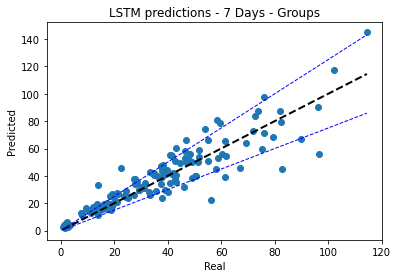

In [10]:
data_days = data_days_groups.copy()
columns_with_errors = data_days.sum()[data_days.sum() == 0].index.to_list()
# columns_with_errors.append(220.0)
data_days.drop(columns=columns_with_errors, inplace=True)

# Se quitan datos agregados para las pruebas
data_days = data_days.iloc[12:, :-9]

level = 1
#data_days = acum_population_levels(data_days, [0], level,  acum = False)

data_history, data_target = hist_targ_dfs(data_days, 2)

data_history.sort_index(inplace=True)
data_target.sort_index(inplace=True)

n_test = 7
parameters = {'neurons': 100, 'dropout': 0.1}
name_error = 'LSTM predictions - 7 Days - Groups'
path_error = "../imgs/ips_predictions/prediction_lstm_7_days_groups_new_data_opt2.png"
name_map = '7 days'
path_map = "../imgs/ips_predictions/maps_LSTM_prediction_7_total_data_groups_new_data_opt2.png"
level = 1
acum = False
population = True

dict_pred_groups, pred_lstm_groups, pred_lstm_cases_groups, map_hex_groups_total,dict_total_pred_groups = lstm_predictions(data_days, data_history, data_target, 2, n_test, parameters, name_error, path_error, name_map, path_map, level, population, acum, geometry='group_id')

model compiled 0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               48800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 48,901
Trainable params: 48,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
159/159 [==============================] - 3s 20ms/step - loss: 0.1986 - val_loss: 0.1774
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1327 - val_loss: 0.0082
Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0734 - val_loss: 0.0621
Epoch 4/100
159/159 [==============================] -

Epoch 22/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 1.9297e-04
Epoch 23/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0144 - val_loss: 0.0040
Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0219
Epoch 25/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.0015
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0138 - val_loss: 2.0379e-04
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 4.3598e-04
Epoch 28/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 29/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0176
Epoch 30/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0018
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - 

Epoch 18/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0208 - val_loss: 0.0250
Epoch 19/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 20/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0341
Epoch 21/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0188 - val_loss: 0.0373
Epoch 22/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0192 - val_loss: 8.1699e-05
Epoch 23/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 0.0043
Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0176 - val_loss: 0.0293
Epoch 25/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0141 - val_loss: 0.0425
Epoch 26/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0130
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.

Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0559 - val_loss: 0.0012
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0461 - val_loss: 1.3244e-04
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0278 - val_loss: 1.1596e-04
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0354 - val_loss: 1.7104e-04
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0301 - val_loss: 0.0141
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0232 - val_loss: 0.0013
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0226 - val_loss: 0.0046
Epoch 11/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0223 - val_loss: 8.6607e-04
Epoch 12/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0169 - val_loss: 0.0136
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - lo

Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0535 - val_loss: 0.0375
Epoch 11/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0349 - val_loss: 0.0072
Epoch 12/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0276 - val_loss: 0.0016
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0335 - val_loss: 0.0089
Epoch 14/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0217 - val_loss: 4.4634e-04
Epoch 15/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0316 - val_loss: 0.0033
Epoch 16/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0377 - val_loss: 0.0153
Epoch 17/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0344 - val_loss: 0.0016
Epoch 18/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0217 - val_loss: 0.0072
Epoch 19/100
159/159 [==============================] - 1s 4ms/step - loss: 0.

159/159 [==============================] - 1s 4ms/step - loss: 0.0580 - val_loss: 0.0538
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0437 - val_loss: 0.0106
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0413 - val_loss: 0.0340
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0327 - val_loss: 0.0785
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0343 - val_loss: 0.0012
Epoch 11/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0392 - val_loss: 0.0970
Epoch 12/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0291 - val_loss: 0.0123
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0255 - val_loss: 2.2973e-05
Epoch 14/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0023
Epoch 15/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0201 - val_loss:

Saved model to disk
model compiled 16
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               48800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 48,901
Trainable params: 48,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
159/159 [==============================] - 1s 6ms/step - loss: 0.2273 - val_loss: 0.1588
Epoch 2/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0994 - val_loss: 3.3167e-04
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0781 - val_loss: 0.0158
Epoch 4/100
159/159 [=========

Epoch 33/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0177 - val_loss: 0.0032
Epoch 34/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0203 - val_loss: 1.1346e-04
Epoch 35/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 00035: early stopping
Saved model to disk
model compiled 18
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               48800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 48,901
Trainable params: 48,901
Non-trainable params: 0
_________________________________________________________________
None

159/159 [==============================] - 1s 4ms/step - loss: 0.0155 - val_loss: 0.0052
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 7.3974e-04
Epoch 32/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0040
Epoch 33/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0010
Epoch 34/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0161 - val_loss: 0.0043
Epoch 35/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0135 - val_loss: 7.6645e-04
Epoch 36/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0187 - val_loss: 9.5992e-04
Epoch 37/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0130 - val_loss: 0.0047
Epoch 38/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0207 - val_loss: 0.0033
Epoch 39/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0139 

159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
Loaded model from disk
159 159 0
160 159 1
161 159 2
162 159 3
163 159 4
164 159 5
165 159 6
MSE: 2671.757788
RMSE: 51.689049
MAE: 39.429444
MAPE: 19.173170

Quantile 1, between 65.85714285714286 and 143.53571428571428
MSE: 678.321965
RMSE: 26.044615
MAE: 22.726557
MAPE: 24.709587

Quantile 2, between 143.53571428571428 and 209.92857142857142
MSE: 1360.563371
RMSE: 36.885815
MAE: 29.715188
MAPE: 15.625437

Quantile 3, between 209.92857142857142 and 290.60714285714283
MSE: 2503.685587
RMSE: 50.036842
MAE: 42.447744
MAPE: 17.385326

Quantile 4, between 290.60714285714283 and 462.28571428571433
MSE: 5897.915793
RMSE: 76.797889
MAE: 61.712294
MAPE

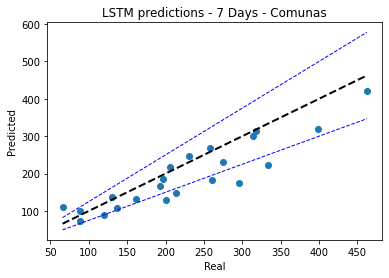

In [144]:
data_days = data_days_comunas.copy()
columns_with_errors = data_days.sum()[data_days.sum() == 0].index.to_list()
# columns_with_errors.append(220.0)
data_days.drop(columns=columns_with_errors, inplace=True)

# Se quitan datos agregados para las pruebas
data_days = data_days.iloc[12:, :-9]

level = 1
#data_days = acum_population_levels(data_days, [0], level,  acum = False)

data_history, data_target = hist_targ_dfs(data_days, 2)

data_history.sort_index(inplace=True)
data_target.sort_index(inplace=True)

n_test = 7
parameters = {'neurons': 100, 'dropout': 0.1}
name_error = 'LSTM predictions - 7 Days - Comunas'
path_error = "../imgs/ips_predictions/prediction_lstm_7_days_comunas_new_data_opt2.png"
name_map = '7 days'
path_map = "../imgs/ips_predictions/maps_LSTM_prediction_7_total_data_comunas_new_data_opt2.png"
level = 1

acum = False
population = True

dict_pred_comunas, pred_lstm_comunas, pred_lstm_cases_comunas, map_hex_comunas_total,dict_total_pred_comunas = lstm_predictions(data_days, data_history, data_target, 2, n_test, parameters, name_error, path_error, name_map, path_map, level, population, acum, geometry='comuna_id')

In [ ]:
data_days = data_days_hex.copy()
columns_with_errors = data_days.sum()[data_days.sum() == 0].index.to_list()
# columns_with_errors.append(220.0)
data_days.drop(columns=columns_with_errors, inplace=True)

# Se quitan datos agregados para las pruebas
data_days = data_days.iloc[12:, :-9]

level = 1
#data_days = acum_population_levels(data_days, [0], level,  acum = False)

data_history, data_target = hist_targ_dfs(data_days, 2)

data_history.sort_index(inplace=True)
data_target.sort_index(inplace=True)

n_test = 7
parameters = {'neurons': 100, 'dropout': 0.1}
name_error = 'LSTM predictions - 7 Days - Hex'
path_error = "../imgs/ips_predictions/prediction_lstm_7_days_hex_new_data_opt2.png"
name_map = '7 days'
path_map = "../imgs/ips_predictions/maps_LSTM_prediction_7_total_data_hex_new_data_opt2.png"
level = 1

acum = False
population = True

dict_pred_hex, pred_lstm_hex, pred_lstm_cases_hex, map_hex_hex_total,dict_total_pred_hex = lstm_predictions(data_days, data_history, data_target, 2, n_test, parameters, name_error, path_error, name_map, path_map, level, population, acum, geometry='hex_id')

model compiled 0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 100,501
Trainable params: 100,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
159/159 [==============================] - 2s 10ms/step - loss: 0.3193 - val_loss: 0.1679
Epoch 2/100
159/159 [==============================] - 1s 6ms/step - loss: 0.1088 - val_loss: 0.1612
Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0861 - val_loss: 0.2107
Epoch 4/100
159/159 [==============================]

159/159 [==============================] - 1s 6ms/step - loss: 0.0162 - val_loss: 0.0014
Epoch 11/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0218 - val_loss: 0.0932
Epoch 12/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.0079
Epoch 13/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0229 - val_loss: 0.0660
Epoch 14/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0194 - val_loss: 0.0023
Epoch 15/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0205 - val_loss: 0.0011
Epoch 16/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0158 - val_loss: 4.4221e-05
Epoch 17/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0183 - val_loss: 0.0148
Epoch 18/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 2.3469e-04
Epoch 19/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0191 - va

Epoch 1/100
159/159 [==============================] - 1s 8ms/step - loss: 0.3054 - val_loss: 0.0732
Epoch 2/100
159/159 [==============================] - 1s 6ms/step - loss: 0.1041 - val_loss: 0.0629
Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0794 - val_loss: 0.2407
Epoch 4/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0506 - val_loss: 0.2829
Epoch 5/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0528 - val_loss: 0.0116
Epoch 6/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0469 - val_loss: 0.0021
Epoch 7/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0373 - val_loss: 0.0584
Epoch 8/100
159/159 [==============================] - 1s 7ms/step - loss: 0.0330 - val_loss: 0.0071
Epoch 9/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0314 - val_loss: 0.0568
Epoch 10/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0252 - val_lo

159/159 [==============================] - 1s 6ms/step - loss: 0.0141 - val_loss: 0.0039
Epoch 29/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 30/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 31/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0380
Epoch 32/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0050
Epoch 33/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0139 - val_loss: 6.5616e-06
Epoch 34/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0132
Epoch 35/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0245
Epoch 36/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0190 - val_loss: 0.0032
Epoch 37/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0169 - val_lo

159/159 [==============================] - 1s 8ms/step - loss: 0.2901 - val_loss: 0.0984
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1465 - val_loss: 0.0582
Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0743 - val_loss: 0.0013
Epoch 4/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0558 - val_loss: 0.0016
Epoch 5/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0418 - val_loss: 0.0065
Epoch 6/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0425 - val_loss: 0.1432
Epoch 7/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0391 - val_loss: 6.6799e-04
Epoch 8/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0338 - val_loss: 0.4292
Epoch 9/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0355 - val_loss: 0.1106
Epoch 10/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0351 - val_loss: 0.02

Epoch 22/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 0.0069
Epoch 23/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0163 - val_loss: 0.0012
Epoch 24/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0141 - val_loss: 0.0038
Epoch 25/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0175 - val_loss: 0.0037
Epoch 26/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0013
Epoch 27/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0079
Epoch 28/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0159 - val_loss: 6.9444e-04
Epoch 29/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0124 - val_loss: 0.0550
Epoch 30/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0099
Epoch 31/100
159/159 [==============================] - 1s 4ms/step - loss: 0.

Epoch 1/100
159/159 [==============================] - 1s 6ms/step - loss: 0.2238 - val_loss: 0.3629
Epoch 2/100
159/159 [==============================] - 1s 4ms/step - loss: 0.1773 - val_loss: 0.0081
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0587 - val_loss: 0.0248
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0537 - val_loss: 0.0274
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0417 - val_loss: 0.1110
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0550 - val_loss: 0.3674
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0564 - val_loss: 0.4457
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0528
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0502 - val_loss: 0.0025
Epoch 10/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0253 - val_lo

159/159 [==============================] - 1s 4ms/step - loss: 0.0214 - val_loss: 0.0183
Epoch 34/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 1.5350e-05
Epoch 35/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0140 - val_loss: 0.0021
Epoch 36/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0020
Epoch 37/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0026
Epoch 38/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 1.0616e-05
Epoch 39/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0051
Epoch 00039: early stopping
Saved model to disk
model compiled 15
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               100400    
_____

159/159 [==============================] - 1s 5ms/step - loss: 0.0280 - val_loss: 0.0416
Epoch 13/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0286 - val_loss: 2.0757e-04
Epoch 14/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0206 - val_loss: 0.0336
Epoch 15/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0137
Epoch 16/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0229
Epoch 17/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0209 - val_loss: 0.0253
Epoch 18/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 0.0872
Epoch 19/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0246 - val_loss: 0.0053
Epoch 20/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0286 - val_loss: 0.0533
Epoch 21/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0235 - val_lo

Epoch 1/100
159/159 [==============================] - 1s 9ms/step - loss: 0.2134 - val_loss: 0.3660
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1354 - val_loss: 0.2910
Epoch 3/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0690 - val_loss: 0.0052
Epoch 4/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0449 - val_loss: 0.3582
Epoch 5/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0466 - val_loss: 0.0124
Epoch 6/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0348 - val_loss: 0.2811
Epoch 7/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0242 - val_loss: 0.2089
Epoch 8/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.8564
Epoch 9/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.2250
Epoch 10/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0320 - val_lo

159/159 [==============================] - 1s 5ms/step - loss: 0.0471 - val_loss: 0.0375
Epoch 21/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0407 - val_loss: 0.0029
Epoch 22/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0333 - val_loss: 0.0199
Epoch 23/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0340 - val_loss: 3.9349e-04
Epoch 24/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0271 - val_loss: 0.0183
Epoch 25/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0275 - val_loss: 1.6569e-04
Epoch 26/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0267 - val_loss: 0.0061
Epoch 27/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0113
Epoch 28/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0229 - val_loss: 0.0463
Epoch 29/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0363 - va

Epoch 10/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0395 - val_loss: 0.0615
Epoch 11/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0309 - val_loss: 0.1004
Epoch 12/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0298 - val_loss: 0.1519
Epoch 13/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0222 - val_loss: 0.0942
Epoch 14/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0219 - val_loss: 0.0029
Epoch 15/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0196 - val_loss: 3.2850e-04
Epoch 16/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0087
Epoch 17/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0297 - val_loss: 2.3853e-04
Epoch 18/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0280 - val_loss: 0.0735
Epoch 19/100
159/159 [==============================] - 1s 5ms/step - loss

Epoch 45/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0161 - val_loss: 0.0051
Epoch 00045: early stopping
Saved model to disk
model compiled 25
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 100,501
Trainable params: 100,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
159/159 [==============================] - 2s 10ms/step - loss: 0.2173 - val_loss: 1.7928
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.1212 - val_loss: 0.0681
Ep

Epoch 24/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0271
Epoch 25/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0284
Epoch 26/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0020
Epoch 27/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0138 - val_loss: 1.5864e-04
Epoch 28/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0017
Epoch 29/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 8.0461e-05
Epoch 30/100
159/159 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 5.7139e-04
Epoch 31/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0170 - val_loss: 0.0031
Epoch 32/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0121 - val_loss: 1.2662e-05
Epoch 33/100
159/159 [==============================] - 1s 5ms/ste

Epoch 12/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0226 - val_loss: 0.0023
Epoch 13/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0297 - val_loss: 0.0310
Epoch 14/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0355 - val_loss: 3.6342e-05
Epoch 15/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0208 - val_loss: 0.0073
Epoch 16/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0011
Epoch 17/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0240 - val_loss: 0.0030
Epoch 18/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0155 - val_loss: 0.0099
Epoch 19/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0113
Epoch 20/100
159/159 [==============================] - 1s 4ms/step - loss: 0.0145 - val_loss: 1.8309e-04
Epoch 21/100
159/159 [==============================] - 1s 4ms/step - loss

Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0613 - val_loss: 0.6870
Epoch 4/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0605 - val_loss: 0.3549
Epoch 5/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0477 - val_loss: 0.0033
Epoch 6/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0423 - val_loss: 0.0396
Epoch 7/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0418 - val_loss: 0.0023
Epoch 8/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0258 - val_loss: 0.0203
Epoch 9/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0347 - val_loss: 0.1313
Epoch 10/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0271 - val_loss: 0.2457
Epoch 11/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0215 - val_loss: 0.0112
Epoch 12/100
159/159 [==============================] - 1s 6ms/step - loss: 0.0211 - val_

In [ ]:
temp_path = '../temp_data' 

if not os.path.exists(temp_path):
    os.makedirs(temp_path)
    
with open(temp_path+'/dict_total_pred_hex.pickle', 'wb') as handle:
    pickle.dump(dict_total_pred_hex, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(temp_path+'/dict_total_pred_comunas.pickle', 'wb') as handle:
    pickle.dump(dict_total_pred_comunas, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(temp_path+'/dict_total_pred_groups.pickle', 'wb') as handle:
    pickle.dump(dict_total_pred_groups, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
temp_path = '../temp_data' 
with open(temp_path+'/dict_total_pred_hex.pickle', 'rb') as handle:
    dict_total_pred_hex = pickle.load(handle)    
with open(temp_path+'/dict_total_pred_comunas.pickle', 'rb') as handle:
    dict_total_pred_comunas = pickle.load(handle)    
with open(temp_path+'/dict_total_pred_groups.pickle', 'rb') as handle:
    dict_total_pred_groups = pickle.load(handle)

## Generación del excel con el formato del grupo integrador

In [12]:
def grupo_integrador(dict_total_pred):
    df_total_pred = pd.DataFrame()
    for key in dict_total_pred:
        data = {'Fecha obs-pry  DD/MM/AAAA':dict_total_pred[key].index, 
            'Identificador de grupo': key ,
           'Valor Observado': dict_total_pred[key].real.astype(int),
           'Valor Proyectado (o pronosticado)': dict_total_pred[key].pred.astype(int)}

        df = pd.DataFrame(data=data)
        df.reset_index(drop=True)

        df_total_pred = df_total_pred.append(df, ignore_index=True)
    
    return df_total_pred


In [13]:
total_pred_hex = grupo_integrador(dict_total_pred_hex)
total_pred_hex['Identificador Espacial'] = total_pred_hex['Identificador de grupo']
columnas = total_pred_hex.columns
total_pred_hex = total_pred_hex[[columnas[0],columnas[4],columnas[1],columnas[2],columnas[3]]]

total_pred_comunas = grupo_integrador(dict_total_pred_comunas)
total_pred_comunas = pd.merge(left=city_hex[['hex_id','comuna_id']], right=total_pred_comunas, left_on='comuna_id',right_on ='Identificador de grupo')
total_pred_comunas = total_pred_comunas.rename(columns={'hex_id': 'Identificador Espacial'})
columnas = total_pred_comunas.columns
total_pred_comunas = total_pred_comunas[[columnas[2],columnas[0],columnas[3],columnas[4],columnas[5]]]

total_pred_groups = grupo_integrador(dict_total_pred_groups)
total_pred_groups = pd.merge(left=city_hex[['hex_id','group_id']], right=total_pred_groups, left_on='group_id',right_on ='Identificador de grupo')
total_pred_groups = total_pred_groups.rename(columns={'hex_id': 'Identificador Espacial'})
columnas = total_pred_groups.columns
total_pred_groups = total_pred_groups[[columnas[2],columnas[0],columnas[3],columnas[4],columnas[5]]]

In [14]:
total_pred_hex

,Fecha obs-pry DD/MM/AAAA,Identificador Espacial,Identificador de grupo,Valor Observado,Valor Proyectado (o pronosticado)
0,2020-03-09,8866f1cec9fffff,8866f1cec9fffff,5,6
1,2020-03-10,8866f1cec9fffff,8866f1cec9fffff,5,6
2,2020-03-11,8866f1cec9fffff,8866f1cec9fffff,5,6
3,2020-03-12,8866f1cec9fffff,8866f1cec9fffff,6,7
4,2020-03-13,8866f1cec9fffff,8866f1cec9fffff,6,6
...,...,...,...,...,...
25061,2020-08-17,8866f1ce9bfffff,8866f1ce9bfffff,17,18
25062,2020-08-18,8866f1ce9bfffff,8866f1ce9bfffff,18,18
25063,2020-08-19,8866f1ce9bfffff,8866f1ce9bfffff,23,20
25064,2020-08-20,8866f1ce9bfffff,8866f1ce9bfffff,24,22


In [15]:
total_pred_comunas

,Fecha obs-pry DD/MM/AAAA,Identificador Espacial,Identificador de grupo,Valor Observado,Valor Proyectado (o pronosticado)
0,2020-03-09,8866f1cec9fffff,19,32,42
1,2020-03-10,8866f1cec9fffff,19,33,41
2,2020-03-11,8866f1cec9fffff,19,39,41
3,2020-03-12,8866f1cec9fffff,19,42,40
4,2020-03-13,8866f1cec9fffff,19,51,45
...,...,...,...,...,...
25061,2020-08-17,8866f1c5e1fffff,11,92,72
25062,2020-08-18,8866f1c5e1fffff,11,103,73
25063,2020-08-19,8866f1c5e1fffff,11,101,85
25064,2020-08-20,8866f1c5e1fffff,11,111,114


In [16]:
total_pred_groups

,Fecha obs-pry DD/MM/AAAA,Identificador Espacial,Identificador de grupo,Valor Observado,Valor Proyectado (o pronosticado)
0,2020-03-09,8866f1cec9fffff,0.0,18,27
1,2020-03-10,8866f1cec9fffff,0.0,20,28
2,2020-03-11,8866f1cec9fffff,0.0,22,27
3,2020-03-12,8866f1cec9fffff,0.0,24,32
4,2020-03-13,8866f1cec9fffff,0.0,28,31
...,...,...,...,...,...
24729,2020-08-17,8866f1ce9bfffff,94.0,14,14
24730,2020-08-18,8866f1ce9bfffff,94.0,14,13
24731,2020-08-19,8866f1ce9bfffff,94.0,19,18
24732,2020-08-20,8866f1ce9bfffff,94.0,20,21


In [81]:
data_path = '../temp_data'
with pd.ExcelWriter(data_path+'/predicciones.xlsx') as writer:  
    total_pred_hex.to_excel(writer, sheet_name='Sheet_name_1')
    total_pred_comunas.to_excel(writer, sheet_name='Sheet_name_2')
    total_pred_groups.to_excel(writer, sheet_name='Sheet_name_3')

In [119]:
total_pred_hex.columns

Index(['Fecha obs-pry  DD/MM/AAAA', 'Identificador Espacial',
       'Identificador de grupo', 'Valor Observado',
       'Valor Proyectado (o pronosticado)'],
      dtype='object')

In [141]:
total_pred_hex['Identificador de grupo'].unique()[30]

'8866f1c507fffff'

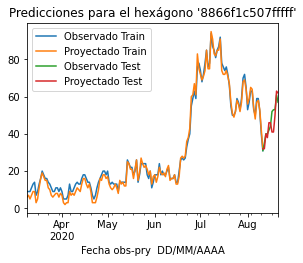

In [142]:
prueba1 = total_pred_hex[total_pred_hex['Identificador de grupo'] == total_pred_hex['Identificador de grupo'].unique()[30]]
prueba1 = prueba1.set_index('Fecha obs-pry  DD/MM/AAAA')[['Valor Observado','Valor Proyectado (o pronosticado)']]
prueba2 = prueba1.iloc[-11:,:]
prueba1 = prueba1.iloc[:-10,:]
prueba1 = prueba1.rename(columns={'Valor Observado': 'Observado Train', 'Valor Proyectado (o pronosticado)' : 'Proyectado Train'})
prueba2 = prueba2.rename(columns={'Valor Observado': 'Observado Test', 'Valor Proyectado (o pronosticado)' : 'Proyectado Test'})

fig, ax = plt.subplots(figsize=(4.5, 3.5))
prueba1.plot(title="Predicciones para el hexágono '8866f1c507fffff'",ax=ax)
prueba2.plot(ax=ax)
plt.savefig('../imgs/ips_predictions/comportamiento_grupo.png', dpi=500)

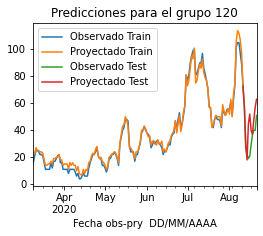

,Valor Observado,Valor Proyectado (o pronosticado)
Fecha obs-pry DD/MM/AAAA,,
2020-08-15,19,45
2020-08-16,21,52
2020-08-17,29,40
2020-08-18,37,37
2020-08-19,40,48
2020-08-20,40,57
2020-08-21,51,63
